<font color='#E27271'>

# *Unveiling Complex Interconnections Among Companies through Learned Embeddings*</font>

-----------------------
<font color='#E27271'>

Ethan Moody, Eugene Oon, and Sam Shinde</font>

<font color='#E27271'>

August 2023</font>

-----------------------
<font color='#00AED3'>

# **Model: FinBERT Modeling & Fine Tuning** </font>
-----------------------

FinBERT is a domain-specific variant of the BERT model, designed specifically for the financial domain. It is pre-trained on a large corpus of financial text, such as news articles, earnings reports, and financial statements, which allows it to learn specialized financial language representations.

We will use [FinBERT](https://huggingface.co/ProsusAI/finbert) to encode summarized Item 1 ("Business") of SEC 10-K reports using XLNet summarization for companies listed on NYSE and NASDAQ. The goal is to predict the GICS sector mutliclass classification for these companies. For fine-tuning FinBERT, we try with various hyper-parameters and pick the best model at the end of hte experiment.

# [Prologue] Begin Timer

In [ ]:
# Import datetime package for notebook timing
from datetime import date, datetime

# Set starting time for notebook run duration estimation
stime = datetime.now()

# [1] Installs, Imports, and Setup Steps

## [1.1] Complete Initial Installs

In [ ]:
# Install Transformers for NLP
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.6 MB/s eta 0:00:00


In [ ]:
# Install Scikit Plots for model evaluation plotting
!pip install scikit-plot --quiet

## [1.2] Import Packages

In [ ]:
# Load common/general packages
import os, sys
import numpy as np
import pandas as pd
import jax
from jax import numpy as jnp
import json

# Load ML packages
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

# Load visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import scikitplot as skplt

# Load Transformer packages
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModelForSequenceClassification

# Load Google Colab packages
from google.colab import drive

## [1.3] Mount Drive

In [ ]:
# Define path for file reference
path = '/content/gdrive/My Drive/Working'

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## [1.4] Google Colab GPU Check

In [ ]:
# Create function to check for number of available GPUs in Google Colab
def num_gpus():
    """Get the number of available GPUs."""
    try:
        return jax.device_count('gpu')
    except:
        return 0  # No GPU backend found

# Display number of active GPUs
print('Active GPUs:', num_gpus())

Active GPUs: 1


# [2] Modeling Data Preparation

## [2.1] Load & Clean Modeling Data

In [ ]:
# Load JSON data file for Non-S&P 500 data
# Forms the basis for TRAINING and VALIDATION data sets
nsp_data = pd.read_json(path + '/xlnet_nsp_summary_final.json')

# Load JSON data file for S&P 500 data
# Forms the basis for TESTING data set
sp_data = pd.read_json(path + '/xlnet_sp_summary_final.json')

### [2.1.1] Limit Timeframe/Form

In [ ]:
# Limit Non-S&P 500 data to just 2022 10-Ks and reset index
nsp_data_extract = nsp_data[
    (nsp_data['year']==2022) & (nsp_data['formType']=='10-K')]
nsp_data_extract.reset_index(drop=True, inplace=True)

# Limit S&P 500 data to just 2022 10-Ks and reset index
sp_data_extract = sp_data[
    (sp_data['year']==2022) & (sp_data['formType']=='10-K')]
sp_data_extract.reset_index(drop=True, inplace=True)

In [ ]:
# Display dimensions of Non-S&P 500 data and S&P 500 data (initial)
print(f'Non-S&P 500 data shape - initial: {nsp_data_extract.shape}')
print(f'S&P 500 data shape - initial: {sp_data_extract.shape}')

Non-S&P 500 data shape - initial: (3682, 14)
S&P 500 data shape - initial: (500, 14)


In [ ]:
# Display summary info for Non-S&P 500 data (initial)
print(nsp_data_extract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ticker          3682 non-null   object
 1   cik             3682 non-null   int64 
 2   formType        3682 non-null   object
 3   filedAt         3682 non-null   object
 4   linkToTxt       3682 non-null   object
 5   linkToHtml      3682 non-null   object
 6   periodOfReport  3682 non-null   object
 7   year            3682 non-null   int64 
 8   ind             3682 non-null   object
 9   name            3682 non-null   object
 10  sector          3682 non-null   object
 11  industry        3682 non-null   object
 12  industry_group  3682 non-null   object
 13  business        3682 non-null   object
dtypes: int64(2), object(12)
memory usage: 402.8+ KB
None


In [ ]:
# Examine a few samples of Non-S&P 500 data (initial)
display(nsp_data_extract)

,ticker,cik,formType,filedAt,linkToTxt,linkToHtml,periodOfReport,year,ind,name,sector,industry,industry_group,business
0,MBLY,1910139,10-K,2023-03-09T16:15:44-05:00,https://www.sec.gov/Archives/edgar/data/191013...,https://www.sec.gov/Archives/edgar/data/191013...,2022-12-31,2022,NASDAQ,Mobileye Global Inc,Consumer Discretionary,Automobile Components,Automobiles & Components,References to Moovit refer to GG Acquisition L...
1,RIVN,1874178,10-K,2023-02-28T17:15:26-05:00,https://www.sec.gov/Archives/edgar/data/187417...,https://www.sec.gov/Archives/edgar/data/187417...,2022-12-31,2022,NASDAQ,Rivian Automotive Inc,Consumer Discretionary,Automobiles,Automobiles & Components,Business Overview Rivian exists to create prod...
2,LCID,1811210,10-K,2023-02-28T16:09:35-05:00,https://www.sec.gov/Archives/edgar/data/181121...,https://www.sec.gov/Archives/edgar/data/181121...,2022-12-31,2022,NASDAQ,Lucid Group Inc,Consumer Discretionary,Automobiles,Automobiles & Components,OVERVIEW Mission Lucids mission is to inspire ...
3,LEA,842162,10-K,2023-02-09T16:59:45-05:00,https://www.sec.gov/Archives/edgar/data/842162...,https://www.sec.gov/Archives/edgar/data/842162...,2022-12-31,2022,NYSE,Lear Corp,Consumer Discretionary,Automobile Components,Automobiles & Components,ITEM BUSINESS In this Annual Report on Form K ...
4,ALV,1034670,10-K,2023-02-16T09:41:48-05:00,https://www.sec.gov/Archives/edgar/data/103467...,https://www.sec.gov/Archives/edgar/data/103467...,2022-12-31,2022,NYSE,Autoliv Inc,Consumer Discretionary,Automobile Components,Automobiles & Components,Business General Autoliv Inc. Autoliv the Comp...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,GWRS,1434728,10-K,2023-03-08T21:43:32-05:00,https://www.sec.gov/Archives/edgar/data/143472...,https://www.sec.gov/Archives/edgar/data/143472...,2022-12-31,2022,NASDAQ,Global Water Resources Inc,Utilities,Water Utilities,Utilities,BUSINESS Overview GWRI is a water resource man...
3678,PCYO,276720,10-K,2022-11-14T16:36:21-05:00,https://www.sec.gov/Archives/edgar/data/276720...,https://www.sec.gov/Archives/edgar/data/276720...,2022-08-31,2022,NASDAQ,Pure Cycle Corporation,Utilities,Water Utilities,Utilities,Item Business Unless otherwise specified or th...
3679,CDZI,727273,10-K,2023-03-30T16:31:10-04:00,https://www.sec.gov/Archives/edgar/data/727273...,https://www.sec.gov/Archives/edgar/data/727273...,2022-12-31,2022,NASDAQ,Cadiz Inc,Utilities,Water Utilities,Utilities,Description of Business This Form K contains f...
3680,RGCO,1069533,10-K,2022-12-02T14:47:39-05:00,https://www.sec.gov/Archives/edgar/data/106953...,https://www.sec.gov/Archives/edgar/data/106953...,2022-09-30,2022,NASDAQ,RGC Resources Inc,Utilities,Gas Utilities,Utilities,General and Historical Development Resources w...


### [2.1.2] Limit for Classification

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # #
# REMOVE: THIS STEP IS NO LONGER NECESSARY    #
# # # # # # # # # # # # # # # # # # # # # # # #

# # Align Non-S&P 500 and S&P 500 data with other project models
# # NOTE: DROPPING NAMES/TICKERS/CIKS THAT ARE NOT USED IN OTHER PROJECT MODELS

# # Define lists with `name`, `ticker`, and `CIK` values to drop from data
# names_to_drop = [
#     'North European Oil Royalty Trust',
#     'ODP Corp',
#     'Navient Corp',
#     'Booz Allen Hamilton Holding Corporation',
#     'Mesabi Trust',
#     'J W Mays Inc',
#     'Fisker Inc'
#     ]
# tickers_to_drop = [
#     'CAH', 'CBOE', 'C', 'EIX', 'GE', 'ILMN',
#     'INTC', 'MA', 'MCD', 'PRU', 'SYF'
#     ]
# ciks_to_drop = [
#     '0000721371', '0001374310', '0000831001',
#     '0000827052', '0000040545', '0001110803',
#     '0000050863', '0001141391', '0000063908',
#     '0001137774', '0001601712'
#     ]

# # Create query_str to limit Non-S&P 500 data to rows not in `name` values
# query_str_nsp = (
#     f"name not in {names_to_drop}"
# )

# # Create a query_str to limit S&P 500 data to rows not in `ticker`/`cik` values
# query_str_sp = (
#     f"ticker not in {tickers_to_drop} and "
#     f"cik not in {ciks_to_drop}"
# )

# # Apply query to Non-S&P 500 data and reset index
# nsp_data_extract = nsp_data_extract.query(query_str_nsp)
# nsp_data_extract.reset_index(drop=True, inplace=True)

# # Apply query to S&P 500 data and reset index
# sp_data_extract = sp_data_extract.query(query_str_sp)
# sp_data_extract.reset_index(drop=True, inplace=True)

In [ ]:
# Limit Non-S&P 500 data to `business` and `sector` only and reset index
nsp_data_extract = nsp_data_extract[['business', 'sector']]
nsp_data_extract.reset_index(drop=True, inplace=True)

# Limit S&P 500 data to `business` and `sector` only and reset index
sp_data_extract = sp_data_extract[['business', 'sector']]
sp_data_extract.reset_index(drop=True, inplace=True)

In [ ]:
# Update Non-S&P 500 data to have only 10 `sector` values (classes)
# Merge 'Consumer Discretionary' and 'Consumer Staples' due to similarities
nsp_data_extract['sector'] = nsp_data_extract['sector'].replace(
    'Consumer Discretionary', 'Consumer Discretionary and Staples')
nsp_data_extract['sector'] = nsp_data_extract['sector'].replace(
    'Consumer Staples', 'Consumer Discretionary and Staples')

# Update S&P 500 data to have only 10 `sector` values (classes)
# Merge 'Consumer Discretionary' and 'Consumer Staples' due to similarities
sp_data_extract['sector'] = sp_data_extract['sector'].replace(
    'Consumer Discretionary', 'Consumer Discretionary and Staples')
sp_data_extract['sector'] = sp_data_extract['sector'].replace(
    'Consumer Staples', 'Consumer Discretionary and Staples')

In [ ]:
# Encode `sector` labels for classification task
labels = sorted(nsp_data_extract.sector.dropna().unique())
label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index

# Display labels by `sector`
display(label_dict)

{'Communication Services': 0,
 'Consumer Discretionary and Staples': 1,
 'Energy': 2,
 'Financials': 3,
 'Health Care': 4,
 'Industrials': 5,
 'Information Technology': 6,
 'Materials': 7,
 'Real Estate': 8,
 'Utilities': 9}

In [ ]:
# Update Non-S&P 500 data with `sector` labels
nsp_data_extract['label'] = nsp_data_extract.sector.replace(label_dict)

# Update TESTING data with `sector` labels
sp_data_extract['label'] = sp_data_extract.sector.replace(label_dict)

In [ ]:
# Display dimensions of Non-S&P 500 and S&P 500 data (limited)
print(f'Non-S&P 500 data shape - limited: {nsp_data_extract.shape}')
print(f'S&P 500 data shape - limited: {sp_data_extract.shape}')

Non-S&P 500 data shape - limited: (3682, 3)
S&P 500 data shape - limited: (500, 3)


In [ ]:
# Display summary info for Non-S&P 500 data (post-limiting)
print(nsp_data_extract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   business  3682 non-null   object
 1   sector    3682 non-null   object
 2   label     3682 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 86.4+ KB
None


In [ ]:
# Examine a few samples of Non-S&P 500 data (post-limiting)
display(nsp_data_extract)

,business,sector,label
0,References to Moovit refer to GG Acquisition L...,Consumer Discretionary and Staples,1
1,Business Overview Rivian exists to create prod...,Consumer Discretionary and Staples,1
2,OVERVIEW Mission Lucids mission is to inspire ...,Consumer Discretionary and Staples,1
3,ITEM BUSINESS In this Annual Report on Form K ...,Consumer Discretionary and Staples,1
4,Business General Autoliv Inc. Autoliv the Comp...,Consumer Discretionary and Staples,1
...,...,...,...
3677,BUSINESS Overview GWRI is a water resource man...,Utilities,9
3678,Item Business Unless otherwise specified or th...,Utilities,9
3679,Description of Business This Form K contains f...,Utilities,9
3680,General and Historical Development Resources w...,Utilities,9


### [2.1.3] Remove Null Values

In [ ]:
# Identify total number of null values in Non-S&P 500 data
nsp_data_extract_null_ct = nsp_data_extract['sector'].isnull().sum()
print(f'Non-S&P 500 data null values - limited: {nsp_data_extract_null_ct}')

Non-S&P 500 data null values - limited: 0


In [ ]:
# Examine a few samples of Non-S&P 500 data where `sector` is null
nsp_data_extract_nulls = nsp_data_extract[nsp_data_extract['sector'].isnull()]
display(nsp_data_extract_nulls)

,business,sector,label


In [ ]:
# Remove null values from Non-S&P 500 data and reset index
nsp_data_extract.dropna(inplace=True)
nsp_data_extract.reset_index(drop=True, inplace=True)

# Remove null values from S&P 500 data and reset index
sp_data_extract.dropna(inplace=True)
sp_data_extract.reset_index(drop=True, inplace=True)

In [ ]:
# Display summary info for Non-S&P 500 data (post-null value removal)
print(nsp_data_extract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   business  3682 non-null   object
 1   sector    3682 non-null   object
 2   label     3682 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 86.4+ KB
None


In [ ]:
# Examine a few samples of Non-S&P 500 data (post-null value removal)
display(nsp_data_extract)

,business,sector,label
0,References to Moovit refer to GG Acquisition L...,Consumer Discretionary and Staples,1
1,Business Overview Rivian exists to create prod...,Consumer Discretionary and Staples,1
2,OVERVIEW Mission Lucids mission is to inspire ...,Consumer Discretionary and Staples,1
3,ITEM BUSINESS In this Annual Report on Form K ...,Consumer Discretionary and Staples,1
4,Business General Autoliv Inc. Autoliv the Comp...,Consumer Discretionary and Staples,1
...,...,...,...
3677,BUSINESS Overview GWRI is a water resource man...,Utilities,9
3678,Item Business Unless otherwise specified or th...,Utilities,9
3679,Description of Business This Form K contains f...,Utilities,9
3680,General and Historical Development Resources w...,Utilities,9


### [2.1.4] Remove Missing Values

In [ ]:
# Identify total number of missing `business` values in Non-S&P 500 data
nsp_data_extract_missing_ct = (nsp_data_extract['business']=='').sum()
print(f'Non-S&P 500 data missing `business` values - limited: {nsp_data_extract_missing_ct}')

Non-S&P 500 data missing `business` values - limited: 0


In [ ]:
# Examine a few samples of Non-S&P 500 data where `business` is missing
nsp_data_extract_missing = nsp_data_extract[nsp_data_extract['business']=='']
display(nsp_data_extract_missing)

,business,sector,label


In [ ]:
# Remove missing `business` values from Non-S&P 500 data and reset index
nsp_data_extract = nsp_data_extract[nsp_data_extract['business']!='']
nsp_data_extract.reset_index(drop=True, inplace=True)

# Remove missing `business` values from S&P 500 data and reset index
sp_data_extract = sp_data_extract[sp_data_extract['business']!='']
sp_data_extract.reset_index(drop=True, inplace=True)

In [ ]:
# Display summary info for Non-S&P 500 data (post-missing value removal)
print(nsp_data_extract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   business  3682 non-null   object
 1   sector    3682 non-null   object
 2   label     3682 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 86.4+ KB
None


In [ ]:
# Examine a few samples of Non-S&P 500 data (post-missing value removal)
display(nsp_data_extract)

,business,sector,label
0,References to Moovit refer to GG Acquisition L...,Consumer Discretionary and Staples,1
1,Business Overview Rivian exists to create prod...,Consumer Discretionary and Staples,1
2,OVERVIEW Mission Lucids mission is to inspire ...,Consumer Discretionary and Staples,1
3,ITEM BUSINESS In this Annual Report on Form K ...,Consumer Discretionary and Staples,1
4,Business General Autoliv Inc. Autoliv the Comp...,Consumer Discretionary and Staples,1
...,...,...,...
3677,BUSINESS Overview GWRI is a water resource man...,Utilities,9
3678,Item Business Unless otherwise specified or th...,Utilities,9
3679,Description of Business This Form K contains f...,Utilities,9
3680,General and Historical Development Resources w...,Utilities,9


### [2.1.5] Deduplicate

In [ ]:
# Identify total number of duplicate records in Non-S&P 500 data
nsp_data_extract_dupes_ct = nsp_data_extract.duplicated().sum()
print(f'Non-S&P 500 data duplicate records - limited: {nsp_data_extract_dupes_ct}')

Non-S&P 500 data duplicate records - limited: 0


In [ ]:
# Examine a few samples of Non-S&P 500 data where duplicate records exist
nsp_data_extract_dupes = nsp_data_extract[nsp_data_extract.duplicated()]
display(nsp_data_extract_dupes)

,business,sector,label


In [ ]:
# Deduplicate records from Non-S&P 500 data and reset index
nsp_data_extract.drop_duplicates(inplace=True)
nsp_data_extract.reset_index(drop=True, inplace=True)

# Deduplicate from S&P 500 data and reset index
sp_data_extract.drop_duplicates(inplace=True)
sp_data_extract.reset_index(drop=True, inplace=True)

In [ ]:
# Display summary info for Non-S&P 500 data (post-deduping)
print(nsp_data_extract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   business  3682 non-null   object
 1   sector    3682 non-null   object
 2   label     3682 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 86.4+ KB
None


In [ ]:
# Examine a few samples of Non-S&P 500 data (post-deduping)
display(nsp_data_extract)

,business,sector,label
0,References to Moovit refer to GG Acquisition L...,Consumer Discretionary and Staples,1
1,Business Overview Rivian exists to create prod...,Consumer Discretionary and Staples,1
2,OVERVIEW Mission Lucids mission is to inspire ...,Consumer Discretionary and Staples,1
3,ITEM BUSINESS In this Annual Report on Form K ...,Consumer Discretionary and Staples,1
4,Business General Autoliv Inc. Autoliv the Comp...,Consumer Discretionary and Staples,1
...,...,...,...
3677,BUSINESS Overview GWRI is a water resource man...,Utilities,9
3678,Item Business Unless otherwise specified or th...,Utilities,9
3679,Description of Business This Form K contains f...,Utilities,9
3680,General and Historical Development Resources w...,Utilities,9


### [2.1.6] Class Counts Summary

In [ ]:
# Check for data imbalance within Non-S&P 500 data `sector` values
nsp_data_extract.sector.value_counts()

Health Care                           954
Financials                            636
Consumer Discretionary and Staples    521
Industrials                           472
Information Technology                438
Energy                                170
Real Estate                           167
Communication Services                160
Materials                             120
Utilities                              44
Name: sector, dtype: int64

### [2.1.7] Finalize Data

In [ ]:
# Finalize Non-S&P 500 data for TRAINING and VALIDATION
data_df = nsp_data_extract

# Finalize S&P 500 data for TESTING
test_df = sp_data_extract

In [ ]:
# Display dimensions of Non-S&P 500 and S&P 500 data (final)
print(f'Non-S&P 500 data shape - final: {data_df.shape}')
print(f'S&P 500 data shape - final: {test_df.shape}')

Non-S&P 500 data shape - final: (3682, 3)
S&P 500 data shape - final: (500, 3)


## [2.2] Partition Data for Modeling

In [ ]:
# Split and relabel final Non-S&P 500 set into TRAINING and VALIDATION subsets
# Note: 15% Non-S&P 500 volume allocated from TRAINING to VALIDATION
X_train, X_val, y_train, y_val = train_test_split(
    data_df.index.values,
    data_df.label.values,
    test_size=0.15,
    random_state=42,
    stratify=data_df.label.values)

In [ ]:
# Relabel final S&P 500 set into TESTING set
X_test = test_df.index.values
y_test = test_df.label.values

In [ ]:
# Check TRAINING, VALIDATION, and TESTING set sizes
print('TRAINING data shape:', X_train.shape, y_train.shape)
print('VALIDATION data shape:', X_val.shape, y_val.shape)
print('TESTING data shape:', X_test.shape, y_test.shape)

TRAINING data shape: (3129,) (3129,)
VALIDATION data shape: (553,) (553,)
TESTING data shape: (500,) (500,)


In [ ]:
# Show distribution of TRAINING and VALIDATION records by `sector`/`label`
data_df['data_type'] = ['not_set'] * data_df.shape[0]
data_df.loc[X_train, 'data_type'] = 'train'
data_df.loc[X_val, 'data_type'] = 'val'
data_df.groupby(['sector', 'label', 'data_type']).count()

business
sector                             label data_type          
Communication Services             0     train           136
                                         val              24
Consumer Discretionary and Staples 1     train           443
                                         val              78
Energy                             2     train           144
                                         val              26
Financials                         3     train           541
                                         val              95
Health Care                        4     train           811
                                         val             143
Industrials                        5     train           401
                                         val              71
Information Technology             6     train           372
                                         val              66
Materials                          7     train           102
                                         val              18
Real Estate                        8     train           142
                                         val              25
Utilities                          9     train            37
                                         val               7

In [ ]:
# Define/create labels for TRAINING, VALIDATION, and TESTING sets
train_labels = np.asarray(y_train, dtype='int')
valid_labels = np.asarray(y_val, dtype='int')
test_labels = np.asarray(y_test, dtype='int')

In [ ]:
# Display sample of labels from TRAINING and VALIDATION sets
print(f'TRAINING Labels[:10]: {train_labels[:10]}')
print(f'VALIDATION Labels[:10]: {valid_labels[:10]}')

TRAINING Labels[:10]: [3 6 1 5 6 6 6 2 4 5]
VALIDATION Labels[:10]: [4 3 4 8 4 7 5 6 3 6]


In [ ]:
# Prepare TRAINING, VALIDATION, and TESTING set records for examination
train_texts = list(data_df['business'].loc[data_df.index[X_train]].values)
valid_texts = list(data_df['business'].loc[data_df.index[X_val]].values)
test_texts = list(test_df['business'].values) # Leave TESTING data unexamined

In [ ]:
# Examine sample TRAINING set records
train_texts[:2]

['Business Cherry Hill Mortgage Investment Corporation is a publicly traded residential real estate finance company focused on acquiring investing in and managing residential mortgage assets in the United States. Our common stock our . We operate so as to continue to qualify to be taxed as a REIT under the Code. Subject to market conditions we may also invest in other cash flowing residential mortgage assets. For information regarding the segments in which we operate see Item . Our Targeted Asset Classes Our primary targeted asset classes currently consist of RMBS including Agency RMBS residential mortgage passthrough certificates CMOs and TBAs and Servicing Related Assets consisting of MSRs and Excess MSRs. Servicing Related Asset Strategy. Our RMBS strategy focuses primarily on the acquisition and ownership of Agency RMBS that are wholepool residential mortgage passthrough certificates. Accordingly drop income on TBA dollar rolls generally represents the economic equivalent of the ne

In [ ]:
# Examine sample VALIDATION set records
valid_texts[:2]

['Busines s Unless the context indicates otherwise the terms Zynerba Zynerba Pharmaceuticals we us our our company and our business refer to Zynerba Pharmaceuticals Inc. Company Overview We are the leader in pharmaceuticallyproduced transdermal cannabinoid therapies for orphan neuropsychiatric disorders. Approximately of the patients enrolled will have complete methylation of their FMR gene and approximately patients will have partial methylation of their FMR gene. Patients will be randomized to either Zygel or placebo. The ABCC FXS Social Avoidance subscale is the same primary endpoint used in the CONNECTFX trial. Topline results for the RECONNECT trial are expected in the first half of . We believe Zygel may provide an effective treatment for patients with FXS that have a completely methylated FMR gene based on its capacity to interact with the endocannabinoid system which is compromised in patients with FXS. FABC In September we reported the results for our openlabel exploratory Pha

# [3] FinBERT Fine-Tuning

## [3.1] Model Setup Steps

In [ ]:
# Define model checkpoints for all evaluated FinBERT PTMs
BASE_MODEL_CHECKPOINT = 'ProsusAI/finbert'
# ESG_MODEL_CHECKPOINT = 'yiyanghkust/finbert-esg' # TF MODEL FILE NOT AVAILABLE?
# TONE_MODEL_CHECKPOINT = 'yiyanghkust/finbert-tone' # TF MODEL FILE NOT AVAILABLE?

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Documentation BASE  : https://huggingface.co/ProsusAI/finbert         #
# Documentation ESG   : https://huggingface.co/yiyanghkust/finbert-esg  #
# Documentation Tone  : https://huggingface.co/yiyanghkust/finbert-tone #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [ ]:
# Define tokenizers and instantiate models
finbert_tokenizer_base = AutoTokenizer.from_pretrained(
    BASE_MODEL_CHECKPOINT)
finbert_model_base = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL_CHECKPOINT)
# finbert_tokenizer_base = BertTokenizer.from_pretrained(
    # BASE_MODEL_CHECKPOINT)
# finbert_model_base = TFBertModel.from_pretrained(
    # BASE_MODEL_CHECKPOINT)

#############################################################################
## CODE FOR ADDITIONAL FinBERT PTMs
#############################################################################
# finbert_tokenizer_esg = AutoTokenizer.from_pretrained(
    # ESG_MODEL_CHECKPOINT)
# finbert_model_esg = AutoModelForSequenceClassification.from_pretrained(
    # ESG_MODEL_CHECKPOINT)
# finbert_tokenizer_tone = AutoTokenizer.from_pretrained(
    # TONE_MODEL_CHECKPOINT)
# finbert_model_tone = AutoModelForSequenceClassification.from_pretrained(
    # TONE_MODEL_CHECKPOINT)

In [ ]:
# Set max sequence length for tokenization
max_length = 512

# Tokenize/pad/truncate TRAINING set
train_encodings = finbert_tokenizer_base(
    train_texts,
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors='tf')

# Tokenize/pad/truncate VALIDATION set
valid_encodings = finbert_tokenizer_base(
    valid_texts,
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors='tf')

# Tokenize/pad/truncate TESTING set
test_encodings = finbert_tokenizer_base(
    test_texts,
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors='tf')

In [ ]:
# Create function for FinBERT PTM fine-tuning - multiclass classification (1)
def create_finbert_multiclass_model_poolerlite(checkpoint,
                                               num_classes=10,
                                               hidden_size=max_length,
                                               dropout=0,
                                               learning_rate=0.00005):
    """
    Build a multiclass classification model for fine-tuning FinBERT.
    Use BERT pooler output for classification purposes.
    """
    # Define FinBERT model
    fbert_model = TFBertModel.from_pretrained(checkpoint)

    # Make FinBERT model non-fully trainable
    fbert_model.trainable = False

    # Define FinBERT inputs: input IDs, token IDs, and attention mask
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # Organize FinBERT inputs in a dictionary
    fbert_inputs = {'input_ids': input_ids,
                    'token_type_ids': token_type_ids,
                    'attention_mask': attention_mask}

    # Define FinBERT output/last hidden state
    fbert_out = fbert_model(fbert_inputs)

    # Extract pooler token for classification purposes
    pooler_token = fbert_out[1]

    # Create hidden (dense) layer/head for NN
    hidden = tf.keras.layers.Dense(
        hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    # Apply softmax activiation to final layer of NN for classification
    classification = tf.keras.layers.Dense(
        num_classes, activation='softmax', name='classification_layer')(hidden)

    # Define model output layer
    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[classification])

    # Compile model with specified loss, optimizer, and key metrics
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics='accuracy')

    return classification_model

In [ ]:
# Create function for FinBERT PTM fine-tuning - multiclass classification (2)
def create_finbert_multiclass_model_pooler(checkpoint,
                                           num_classes=10,
                                           hidden_size=max_length,
                                           dropout=0.3,
                                           learning_rate=0.00005):
    """
    Build a multiclass classification model for fine-tuning FinBERT.
    Use BERT pooler output for classification purposes.
    """
    # Define FinBERT model
    fbert_model = TFBertModel.from_pretrained(checkpoint)

    # Make FinBERT model fully trainable (i.e., train all layers of model)
    fbert_model.trainable = True

    # Define FinBERT inputs: input IDs, token IDs, and attention mask
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # Organize FinBERT inputs in a dictionary
    fbert_inputs = {'input_ids': input_ids,
                    'token_type_ids': token_type_ids,
                    'attention_mask': attention_mask}

    # Define FinBERT output/last hidden state
    fbert_out = fbert_model(fbert_inputs)

    # Extract pooler token for classification purposes
    pooler_token = fbert_out[1]

    # Create hidden (dense) layer/head for NN
    hidden = tf.keras.layers.Dense(
        hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    # Apply neural dropout to hidden (dense) layer/head in NN
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Apply softmax activiation to final layer of NN for classification
    classification = tf.keras.layers.Dense(
        num_classes, activation='softmax', name='classification_layer')(hidden)

    # Define model output layer
    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[classification])

    # Compile model with specified loss, optimizer, and key metrics
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics='accuracy')

    return classification_model

In [ ]:
# Create function for FinBERT PTM fine-tuning - multiclass classification (3)
def create_finbert_multiclass_model_avg(checkpoint,
                                        num_classes=10,
                                        hidden_size=max_length,
                                        dropout=0.3,
                                        learning_rate=0.00005):
    """
    Build a multiclass classification model for fine-tuning FinBERT.
    Use average of BERT output tokens for classification.
    """
    # Define FinBERT model
    fbert_model = TFBertModel.from_pretrained(checkpoint)

    # Make FinBERT model fully trainable (i.e., train all layers of model)
    fbert_model.trainable = True

    # Define FinBERT inputs: input IDs, token IDs, and attention mask
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # Organize FinBERT inputs in a dictionary
    fbert_inputs = {'input_ids': input_ids,
                    'token_type_ids': token_type_ids,
                    'attention_mask': attention_mask}

    # Define FinBERT output/last hidden state
    fbert_out = fbert_model(fbert_inputs)

    # Average the output vectors for all tokens for classification purposes
    fbert_avg_tokens = tf.reduce_mean(fbert_out.last_hidden_state, axis=1)

    # Create hidden (dense) layer/head for NN
    hidden = tf.keras.layers.Dense(
        hidden_size, activation='relu', name='hidden_layer')(fbert_avg_tokens)

    # Apply neural dropout to hidden (dense) layer/head in NN
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Apply softmax activiation to final layer of NN for classification
    classification = tf.keras.layers.Dense(
        num_classes, activation='softmax', name='classification_layer')(hidden)

    # Define model output layer
    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[classification])

    # Compile model with specified loss, optimizer, and key metrics
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics='accuracy')

    return classification_model

In [ ]:
# Create function for FinBERT PTM fine-tuning - multiclass classification (4)
def create_finbert_multiclass_model_CNN(checkpoint,
                                        num_classes=10,
                                        num_filters=[100, 100, 50, 25],
                                        kernel_sizes=[2, 3, 4, 5],
                                        hidden_size=max_length,
                                        dropout=0.3,
                                        learning_rate=0.00005):
    """
    Build a multiclass classification model for fine-tuning FinBERT.
    Apply a CNN to the BERT output tokens prior to classification.
    """
    # Define FinBERT model
    fbert_model = TFBertModel.from_pretrained(checkpoint)

    # Make FinBERT model fully trainable (i.e., train all layers of model)
    fbert_model.trainable = True

    # Define FinBERT inputs: input IDs, token IDs, and attention mask
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # Organize FinBERT inputs in a dictionary
    fbert_inputs = {'input_ids': input_ids,
                    'token_type_ids': token_type_ids,
                    'attention_mask': attention_mask}

    # Define FinBERT output/last hidden state
    fbert_out = fbert_model(fbert_inputs)[0]

    # Add CNN layers to FinBERT model
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu')(fbert_out)
        conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    # Define CNN output as the result of all CNN steps above
    conv_output = tf.keras.layers.concatenate(
        conv_layers_for_all_kernel_sizes, axis=1)

    # Create hidden (dense) layer/head for NN
    hidden = tf.keras.layers.Dense(
        hidden_size, activation='relu', name='hidden_layer')(conv_output)

    # Apply neural dropout to hidden (dense) layer/head in NN
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Apply softmax activiation to final layer of NN for classification
    classification = tf.keras.layers.Dense(
        num_classes, activation='softmax', name='classification_layer')(hidden)

    # Define model output layer
    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[classification])

    # Compile model with specified loss, optimizer, and key metrics
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics='accuracy')

    return classification_model

In [ ]:
# Create function for plotting model loss curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  # Capture training and validation loss histories
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Capture training and validation accuracy histories
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Capture number of epochs
  epochs = range(len(history.history['loss']))

  # Plot loss histories
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy histories
  plt.figure()
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
# Develop class weights to address class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data_df.label),
    y=train_labels)

# Display class weights
print("Class Weights:", class_weights)

# Add separator
print("-"*50)

# Store weights by class label
weights={}
for index, weight in enumerate(class_weights):
  weights[index]=weight

# Print weights by class label
print("Weights by Class Label:", weights)

Class Weights: [2.30073529 0.70632054 2.17291667 0.57837338 0.38581998 0.78029925
 0.84112903 3.06764706 2.20352113 8.45675676]
--------------------------------------------------
Weights by Class Label: {0: 2.300735294117647, 1: 0.7063205417607223, 2: 2.1729166666666666, 3: 0.5783733826247689, 4: 0.3858199753390876, 5: 0.7802992518703242, 6: 0.8411290322580646, 7: 3.0676470588235296, 8: 2.203521126760563, 9: 8.456756756756757}


## [3.2] Training/Validation Modeling

### [3.2.1] M4: Avg. All Tokens, Added CNN, Added Large Hidden Layer to Base, and Neural Dropout

In [ ]:
# Create fine-tuned FinBERT base model (iteration 4a)
finbert_model_base_ft_CNN = create_finbert_multiclass_model_CNN(
    checkpoint=BASE_MODEL_CHECKPOINT)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Create history of model results by epoch (iteration 4a)
finbert_model_base_ft_CNN_history = finbert_model_base_ft_CNN.fit(
    [train_encodings.input_ids,
     train_encodings.token_type_ids,
     train_encodings.attention_mask],
    train_labels,
    validation_data=(
        [valid_encodings.input_ids,
         valid_encodings.token_type_ids,
         valid_encodings.attention_mask],
        valid_labels),
    shuffle=True,
    batch_size=6, # Batch size < 8 to avoid ResourceExhaustedError
    epochs=5)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# NOTE: It takes 5-6min to complete an epoch when using a GPU   #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

Epoch 1/5


522/522 [==============================] - 466s 800ms/step - loss: 1.0571 - accuracy: 0.6644 - val_loss: 0.6640 - val_accuracy: 0.8264
Epoch 2/5
522/522 [==============================] - 417s 798ms/step - loss: 0.5543 - accuracy: 0.8434 - val_loss: 0.5544 - val_accuracy: 0.8445
Epoch 3/5
522/522 [==============================] - 417s 799ms/step - loss: 0.3597 - accuracy: 0.9025 - val_loss: 0.4883 - val_accuracy: 0.8626
Epoch 4/5
522/522 [==============================] - 419s 802ms/step - loss: 0.3007 - accuracy: 0.9249 - val_loss: 0.5976 - val_accuracy: 0.8373
Epoch 5/5
522/522 [==============================] - 416s 798ms/step - loss: 0.2453 - accuracy: 0.9354 - val_loss: 0.5487 - val_accuracy: 0.8644


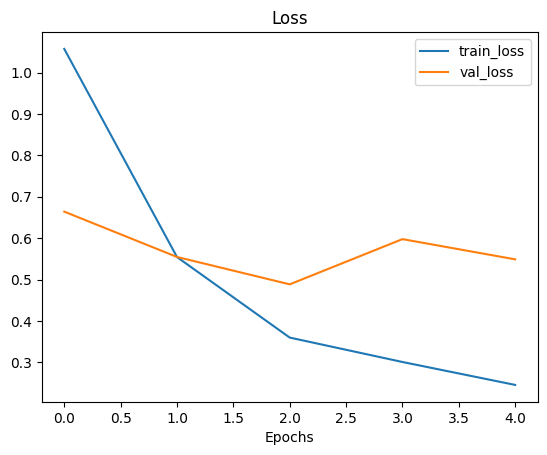

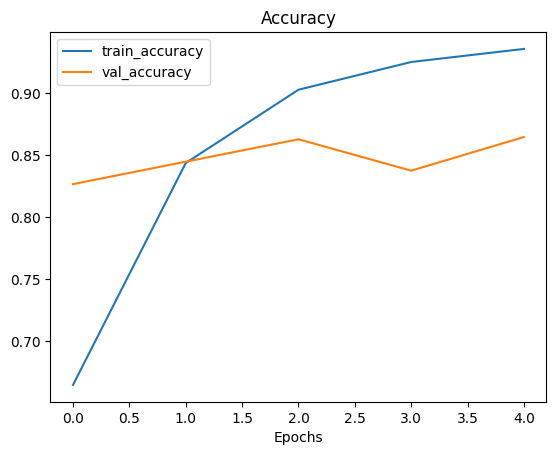

In [ ]:
# Plot history of model results by epoch (iteration 4a)
plot_loss_curves(finbert_model_base_ft_CNN_history)

In [ ]:
# Delete model and clear TF graph/Keras backend to restore RAM (iteration 4a)
del finbert_model_base_ft_CNN
tf.keras.backend.clear_session()

In [ ]:
# Create fine-tuned FinBERT base model with class weights applied (iteration 4b)
finbert_model_base_ft_CNN_cw = create_finbert_multiclass_model_CNN(
    checkpoint=BASE_MODEL_CHECKPOINT)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Create history of model results by epoch (iteration 4b)
finbert_model_base_ft_CNN_cw_history = finbert_model_base_ft_CNN_cw.fit(
    [train_encodings.input_ids,
     train_encodings.token_type_ids,
     train_encodings.attention_mask],
    train_labels,
    validation_data=(
        [valid_encodings.input_ids,
         valid_encodings.token_type_ids,
         valid_encodings.attention_mask],
        valid_labels),
    shuffle=True,
    batch_size=5, # Batch size < 8 to avoid ResourceExhaustedError
    epochs=5,
    class_weight=weights)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# NOTE: It takes 5-6min to complete an epoch when using a GPU   #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

Epoch 1/5


626/626 [==============================] - 463s 660ms/step - loss: 1.2689 - accuracy: 0.6510 - val_loss: 0.7971 - val_accuracy: 0.7559
Epoch 2/5
626/626 [==============================] - 410s 655ms/step - loss: 0.7369 - accuracy: 0.8047 - val_loss: 0.5745 - val_accuracy: 0.8445
Epoch 3/5
626/626 [==============================] - 410s 655ms/step - loss: 0.5231 - accuracy: 0.8571 - val_loss: 0.5205 - val_accuracy: 0.8553
Epoch 4/5
626/626 [==============================] - 410s 655ms/step - loss: 0.4516 - accuracy: 0.8833 - val_loss: 0.6931 - val_accuracy: 0.7975
Epoch 5/5
626/626 [==============================] - 410s 655ms/step - loss: 0.3848 - accuracy: 0.9118 - val_loss: 0.5883 - val_accuracy: 0.8770


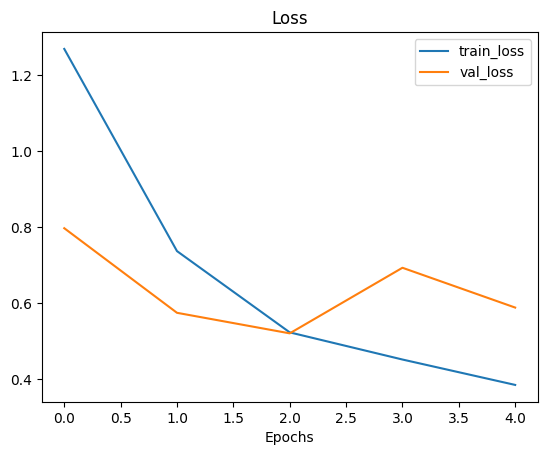

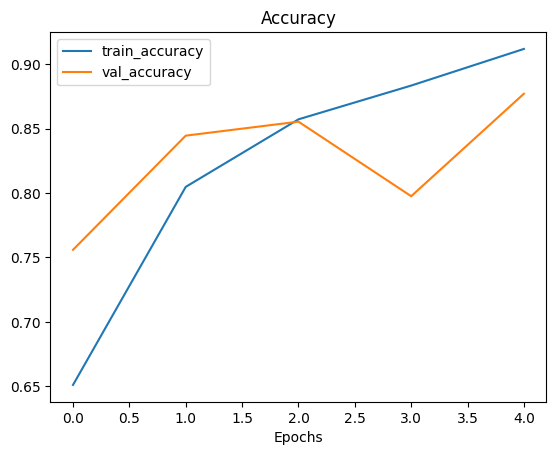

In [ ]:
# Plot history of model results by epoch (iteration 4b)
plot_loss_curves(finbert_model_base_ft_CNN_cw_history)

In [ ]:
# Delete model and clear TF graph/Keras backend to restore RAM (iteration 4b)
# del finbert_model_base_ft_CNN_cw
# tf.keras.backend.clear_session()

###############################################################################
## NOTE: Preserve model for TESTING set predictions - DO NOT DELETE
###############################################################################

# [4] FinBERT+CNN Testing & Evaluation

## [4.1] Generate Model Predictions

In [ ]:
# # Generate class predictions on TESTING set using best-performing FinBERT model
# preds = finbert_model_base_ft_pooler_cw.predict(
#     [test_encodings.input_ids,
#      test_encodings.token_type_ids,
#      test_encodings.attention_mask])

16/16 [==============================] - 23s 1s/step


In [ ]:
# Generate class predictions on TESTING set using best-performing FinBERT model
preds = finbert_model_base_ft_CNN_cw.predict(
    [test_encodings.input_ids,
     test_encodings.token_type_ids,
     test_encodings.attention_mask])

16/16 [==============================] - 24s 1s/step


In [ ]:
# Capture predicted classes from TESTING set predictions
preds_classes = tf.argmax(preds, axis=-1)

# Display predicted classes
display(preds_classes)

<tf.Tensor: shape=(500,), dtype=int64, numpy=
array([5, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 1, 9, 5, 6, 5, 6,
       5, 5, 5, 5, 5, 5, 3, 5, 1, 3, 5, 5, 5, 5, 5, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 3, 5, 1, 1, 1, 1, 1, 1, 1,
       5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1,
       1, 1, 1, 1, 4, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 8, 8, 6, 3, 8, 8, 8, 3, 8, 8, 8, 5, 8, 7, 1, 8,
       8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 7, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 1, 3, 6,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7,
       1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1,
     

## [4.2] Analyze Model Performance

In [ ]:
# Generate multiclass classification report based on TESTING set predictions
cr = classification_report(
    test_labels, preds_classes.numpy(), target_names=labels)

# Display classification report
print(cr)

                                    precision    recall  f1-score   support

            Communication Services       0.95      0.95      0.95        20
Consumer Discretionary and Staples       0.93      0.89      0.91        90
                            Energy       1.00      0.96      0.98        23
                        Financials       0.93      0.92      0.92        72
                       Health Care       0.98      0.97      0.98        65
                       Industrials       0.76      0.87      0.81        75
            Information Technology       0.89      0.86      0.88        65
                         Materials       0.76      0.86      0.81        29
                       Real Estate       1.00      0.77      0.87        31
                         Utilities       0.97      1.00      0.98        30

                          accuracy                           0.90       500
                         macro avg       0.92      0.90      0.91       500
          

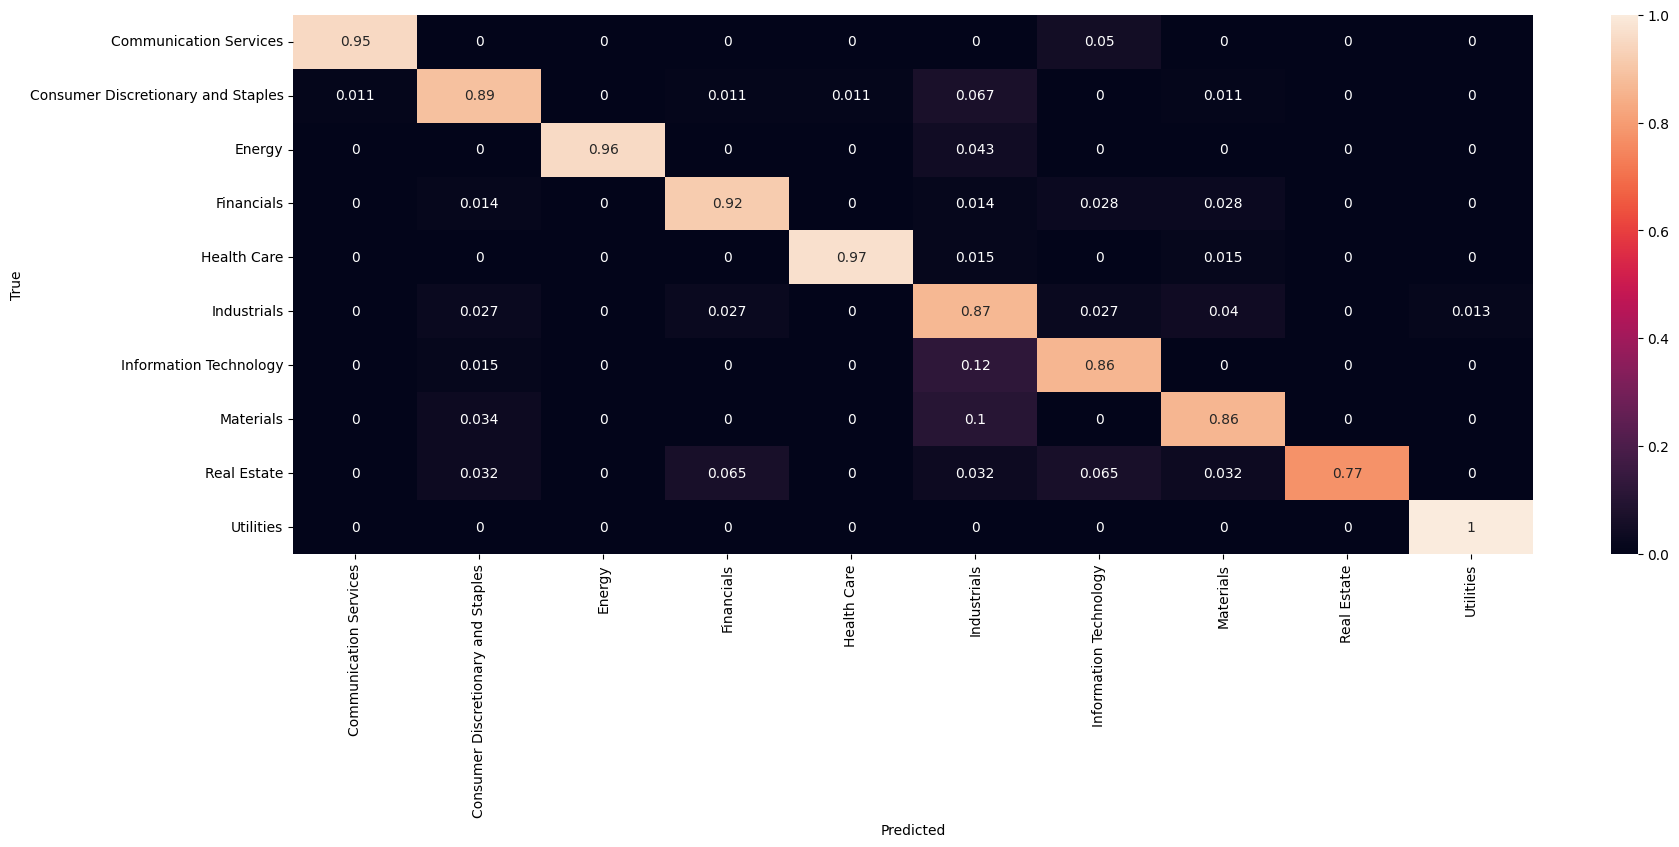

In [ ]:
# Generate a confusion matrix to show TESTING results by class
cm = tf.math.confusion_matrix(test_labels, preds_classes)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

# Display confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=labels,
    yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Display misclassified observations from the TESTING set
for i in np.where(test_labels != preds_classes)[0]:
  true_label = list(
      filter(lambda x: label_dict[x] == test_labels[i], label_dict))[0]
  pred_label = list(
      filter(lambda x: label_dict[x] == preds_classes[i], label_dict))[0]
  print(f'Truth: {test_labels[i]} - {true_label}')
  print(f'Predicted: {preds_classes[i]} - {pred_label}')
  print(f'Text: {test_texts[i]}')
  print('-'*100)

Truth: 1 - Consumer Discretionary and Staples
Predicted: 5 - Industrials
Text: BUSINESS Overview We design develop manufacture sell and lease highperformance fully electric vehicles and energy generation and storage systems and offer services related to our products. We plan to continue leveraging developments in our proprietary Full SelfDriving FSD battery cell and other technologies. We have designed our proprietary powertrain systems to be adaptable efficient reliable and costeffective while withstanding the rigors of an automotive environment. By taking a modular approach to the design of battery systems we can optimize manufacturing capacity of our energy storage products. We designed both products to integrate with Powerwall. Energy Generation and Storage Our expertise in electrical mechanical civil and software engineering allows us to design engineer manufacture and install energy generating and storage products and components including at the residential through utility scale.

# [Epilogue] End Timer

In [ ]:
# Set ending time for notebook run duration estimation
etime = datetime.now()

# Display total time taken to run notebook from start to finish
print(f'Time to run notebook (in min): {((etime-stime).total_seconds())/60}')

Time to run notebook (in min): 36.40474785
